In [ ]:
pip install transformers datasets torch evaluate

In [65]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset,DatasetDict,load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import re

from transformers import AutoTokenizer,AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

**LOADING THE DATA**

In [4]:
dataset = load_dataset("selimyagci/sample_data")

Generating train split: 0 examples [00:00, ? examples/s]

In [84]:
dataframe = pd.DataFrame(dataset['train'])

**DATA OVERVIEW**

In [86]:
dataframe.head()

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


In [68]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37295 entries, 0 to 37294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    37295 non-null  object
 1   label   37195 non-null  object
dtypes: object(2)
memory usage: 582.9+ KB


In [69]:
dataframe.describe().T

,count,unique,top,freq
text,37295,35503,,300
label,37195,6,ft,11226


In [70]:
dataframe['label'].value_counts()

ft     11226
pkg     9617
ct      5061
mr      5016
ch      3688
cnc     2587
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

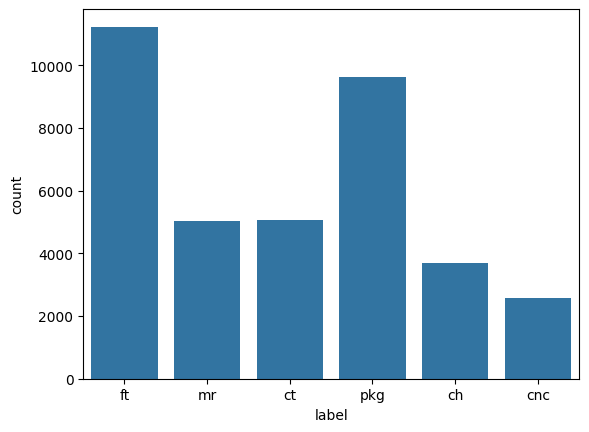

In [71]:
sns.countplot(x="label", data=dataframe)

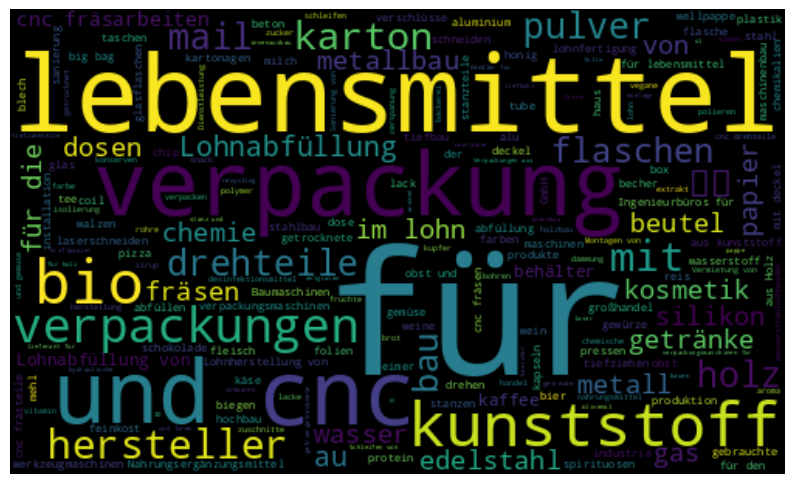

In [72]:
import wordcloud
from wordcloud import WordCloud
words = ' '.join([txt for txt in dataframe['text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(words)

plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**DATA PREPARATION**

*Assumption 0: lower case all words for consistency*

In [87]:
dataframe["text"] = dataframe["text"].str.lower()

*Assumption 1: removing empty labels which might be caused by an issue in data collection*



In [88]:
dataframe = dataframe.dropna()

*Assupmtion 2: removing non german characters*

In [114]:
pattern = '[^a-zA-Z0-9äöüÄÖÜß]'

dataframe = dataframe.applymap(lambda x: re.sub(pattern, " ", x) if pd.notnull(x) else x).sort_values('text')

*Removing empty strings in text column*

In [116]:
dataframe = dataframe.drop(dataframe[dataframe['text'].str.isspace()].index)

*Removing duplicates and keeping last occurences*

In [118]:
dataframe = dataframe.drop_duplicates(subset=['text'], keep='last')

*Mapping labels into integer values*

In [119]:
dataframe.label, mapping = pd.factorize(dataframe.label)
label_names = mapping.to_list()

In [127]:
dataframe.head()

,text,label
50,die norm vertriebs von norm und sonderteile...,0
35337,einwegprodukte für den lebensmittelindustrie,1
19806,geräte und produkte zum schutz der person,0
23316,ce cream,0
20341,flächendesinfektion wasserstoffperoxid,2


DATA SPLITTING

In [128]:
train, tst = train_test_split(dataframe, test_size=0.2, shuffle=True)
valid, test = train_test_split(tst, test_size=0.5)

In [45]:
'''
trainds = Dataset.from_pandas(train)
valds = Dataset.from_pandas(valid)
testds = Dataset.from_pandas(test)
ds = DatasetDict({
    'train': trainds,
    'valid': valds,
    'test': testds
})
'''

**TOKENIZATION**

In [129]:
PRETRAINED = "bert-base-german-dbmdz-uncased"
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/247k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/487k [00:00<?, ?B/s]

In [130]:
def encode(docs):
  encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length', return_attention_mask=True, truncation=True, return_tensors='pt')
  input_ids = encoded_dict['input_ids']
  attention_masks = encoded_dict['attention_mask']
  return input_ids, attention_masks

In [131]:
train_input_ids, train_att_masks = encode(train['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid['text'].values.tolist())
test_input_ids, test_att_masks = encode(test['text'].values.tolist())

In [132]:
train_y = torch.LongTensor(train['label'].values.tolist())
valid_y = torch.LongTensor(valid['label'].values.tolist())
test_y = torch.LongTensor(test['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([26329]), torch.Size([3291]), torch.Size([3292]))

Creating dataloaders

In [133]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 32
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [134]:
labels = len(train.label.unique())
model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED, num_labels=labels,output_attentions=False,output_hidden_states=False)

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [136]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**FINETUNING PRETRAINED MODEL**

In [137]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
LEARNING_RATE = 1e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [138]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/823 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

823/823 train loss: 0.5510068626786929 
103/103 val loss: 0.3432895414603567 
Epoch:  2


Training:   0%|          | 0/823 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

823/823 train loss: 0.2991131559322121 
103/103 val loss: 0.3048029738360817 
Epoch:  3


Training:   0%|          | 0/823 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

823/823 train loss: 0.24026725445517574 
103/103 val loss: 0.28945871612545354 


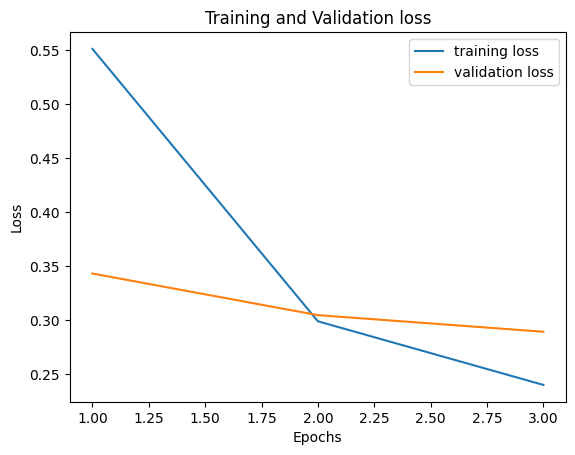

In [139]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

**Test the performance on test set**

In [140]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [143]:
from sklearn.metrics import classification_report

print(classification_report(test_pred, test['label'].to_numpy(),target_names=label_names))

              precision    recall  f1-score   support

          ft       0.91      0.93      0.92       917
         pkg       0.91      0.88      0.90       943
          ch       0.90      0.89      0.89       325
          mr       0.87      0.82      0.84       440
         cnc       0.75      0.81      0.78       197
          ct       0.91      0.94      0.93       470

    accuracy                           0.89      3292
   macro avg       0.88      0.88      0.88      3292
weighted avg       0.89      0.89      0.89      3292



output misclassified ones

In [144]:
test['pred'] = test_pred
test.reset_index(level=0)
print(test[test['label']!=test['pred']].shape)
test[test['label']!=test['pred']][['text','label','pred']].head(10)

(351, 3)


,text,label,pred
13961,test104 mail com,0,3
10234,pumpe für gymnastikball,5,1
5765,handluotion mit handel öl,0,2
23547,vertikale drehmaschine,4,3
4332,schulterpolster für gurtband,4,1
30738,cnc drehteile hamburg aluminium,3,4
24622,biegen von decken stahlblechen,4,3
7182,obst und gemüse transport,0,1
8213,radlaufschalen kunststoff,3,1
1391,hersteller von nahrungsergänzungsmittel,1,0


Saving the model

In [145]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [146]:
model_save_name = 'germanPhrasesClassificationModel.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model,path)